# Reverse optimization of school assessment functions

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.optimize import minimize, LinearConstraint
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

As part of my research into school admissions markets, I model school preferences using a constant elasticity of substitution (CES) function, which enables us to express schools' preferences for well-rounded students. It looks like this

$$u\left(\vec x\right) = \left(\sum_{i=1}^n a_i x_i^\rho\right)^{1/\rho}$$

with parameters $a_i \geq 0$, $\sum a_i =1$, and $\rho\leq1$. The variables $x_i$ represent orthogonal dimensions of student quality with iid uniform distributions (these can be obtained using principal component analysis). $a_i$ represents the value the school assigns to trait $i$, and $\rho$ encodes the elasticity of substitution. For $\rho =1$, $u$ is a linear function and students can substitute proficiency along one dimension for another in a fixed ratio. For values of $\rho$ less than one, students incur diminishing returns if they are "lopsided," i.e. have all their strengths concentrated toward one $x_i$.

Students are admitted to their school if their score exceeds the school&rsquo;s cutoff&mdash;that is, if $u\left(\vec x\right) \geq p$. 

Here I attempt to validate this model by showing that reasonable CES parameters $\vec a$, $\rho$, and $p$ can be derived from data on student scores and outcomes.

This document should be taken as a proof of concept, showing how to do the reverse optimization process, rather than an accurate estimate of what the parameters are in the real world. I chose these two datasets from Kaggle because they were in the correct format, not necessarily because the data is fundamentally accurate. 

I assume that the datasets given reflect admissions outcomes at a *single* school; in my larger model, an arbitrary number of schools with diverse preferences compete for the best students. To make the data visualizable, I use $n=2$ dimensions of student quality throughout.

Let's write a few helper functions first:

In [23]:
# CES utility associated with given input.
def CES(x, a, rho):
    with np.errstate(divide="ignore"):
        return ((x**rho) @ a)**(1 / rho)

# For n=2 case and fixed utility p, gives x2 as a function of x1.
# Used when plotting decision boundary.
def CES_plot(x1, a, rho, p):
    return ((p**rho - a[0] * x1**rho) / a[1])**(1/rho)

## Dataset 1: Binary admissions outcomes

Source: https://www.kaggle.com/msjass/admittest

This dataset contains three columns of student data and binary outcomes on whether the student was admitted. 

In [24]:
scores = pd.read_csv("SampleAdmitData_Train.csv")
scores.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


First we make our $x$ features. I run PCA on the data columns, extract the normalized features, then convert these to percentile scores to obtain a uniform distribution on $[0,1]^2$. The final shape of the data has an interesting striped pattern because of the discrete `rank` column, but it is fundamentally uncorrelated. 

In [31]:
# Extract two principle components
pca = PCA(n_components=2)
scores[['feat1', 'feat2']] = pca.fit_transform(scores[['gre', 'gpa', 'rank']])

# Multiply so that each feature correlates positively with prob of admission
scores['feat1'] *= np.sign(scores['admit'].corr(scores['feat1']))
scores['feat2'] *= np.sign(scores['admit'].corr(scores['feat2']))

# Convert these to percentile rankings
scores[['x1', 'x2']] = scores[['feat1', 'feat2']].rank(pct=True)

scores.to_csv("julia/binaryinp.csv")
# Notice distribution of x1, x2
scores.head()

,admit,gre,gpa,rank,feat1,feat2,x1,x2
0,0,380,3.61,3,-210.866623,-0.242558,0.053333,0.473333
1,1,660,3.67,3,69.133093,-0.539923,0.703333,0.276667
2,1,800,4.00,1,209.135410,1.315087,1.000000,0.876667
3,1,640,3.19,4,49.131492,-1.524717,0.626667,0.060000
4,0,520,2.93,4,-70.868667,-1.400288,0.253333,0.120000


Define the loss function. For any student misclassified by $u(\vec x) \geq p$, we take the absolute difference between their score and the cutoff and add these all up. (You can also take the squared difference.)

In [26]:
def loss(true_admit, X, params):
    a = np.empty(2)
    a[0], a[1], rho, p = params
    
    assessments = CES(X, a, rho)
    admit_pred = assessments >= p
    return sum(0 if admit_pred[i] == true_admit[i] else abs(assessments[i] - p) for i in range(len(true_admit)))

Do the optimization. This one comes out linear, which reflects the fact that PCA has already done most of the work of separating the scores into relevant components. The loss can be further reduced by allowing $\rho$ to exceed one (the optimal value is $1.615$), but this is not considered acceptable in classical economic theory. 

In [27]:
x0 = [0.5] * 4
out = minimize(lambda params: loss(scores['admit'], scores[['x1', 'x2']], params),
               x0=x0,
               constraints=LinearConstraint(np.array([1, 1, 0, 0]), 1, 1),
               bounds=[(0, np.inf),
                       (0, np.inf),
                       (0, 1),
                       (0, 1)])
print(out)

a = np.empty(2)
a[0], a[1], rho, p = out.x

     fun: 10.971272123985687
     jac: array([10.86333299, 11.08666611, -2.63876736,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 171
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([0.51669382, 0.48330618, 1.        , 0.59424247])


Plot. The gray dashes mark the decision boundary and the scatterplot shows the score and true admissions outcomes.

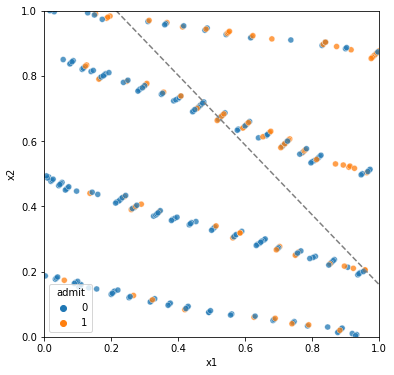

In [7]:
x_p = np.arange(0.01, min(1.01, ((p**rho)/a[0])**(1/rho)), 0.01)
plt.figure(figsize=(6, 6))
plt.plot(x_p, CES_plot(x_p, a, rho, p), color="gray", ls="--")
sb.scatterplot(data=scores, x='x1', y='x2', hue='admit', alpha=0.75)
plt.xlim(0, 1); plt.ylim(0, 1); plt.legend(title='admit', loc='lower left')
plt.savefig("plots/binaryresults.pdf", bbox_inches="tight")

The F-score of this classifier is not particularly good, but neither is the dataset itself. It doesn't contain info on students' experience, letters of rec, essays, etc. There is also a bit of a category error in attempting to use the CES function as a classifier or predictor of outcomes. Instead it is a model of school *preference* parameters which we have coerced to the CES form. If all we want to do is predict outcomes, we can do better with a more sophisticated classifier, perhaps something like KNN.

In [8]:
f1_score(scores['admit'], CES(scores[['x1', 'x2']], a, rho) >= p)

0.5161290322580645

To demonstrate that the optimization process works for $\rho \lt 1$, here is some contrived data that has a nonlinear decision boundary for comparison:

[0.25208745 0.74791255 0.05716192 0.29636905]


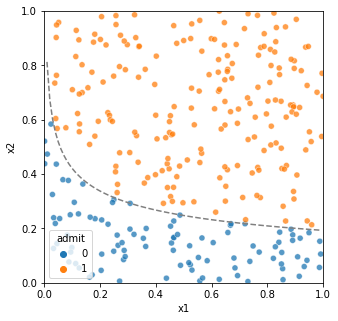

In [9]:
scores = pd.DataFrame(index=range(300))
scores[['x1', 'x2']] = np.random.rand(300, 2)
scores['admit'] = np.array(CES(scores[['x1', 'x2']], [0.25, 0.75], .1) >= 0.3, dtype='int')

x0 = [0.5] * 4
out = minimize(lambda params: loss(scores['admit'], scores[['x1', 'x2']], params),
               x0=x0,
               constraints=LinearConstraint(np.array([1, 1, 0, 0]), 1, 1),
               bounds=[(0, np.inf),
                       (0, np.inf),
                       (0, 1),
                       (0, 1)])
a = np.empty(2); a[0], a[1], rho, p = out.x
print(out.x)

x_p = np.arange(0.01, min(1, ((p**rho)/a[0])**(1/rho)), 0.01)
plt.figure(figsize=(5, 5))
plt.plot(x_p, CES_plot(x_p, a, rho, p), color="gray", ls="--")
sb.scatterplot(data=scores, x='x1', y='x2', hue='admit', alpha=0.75)
plt.xlim(0, 1); plt.ylim(0, 1); plt.legend(title='admit', loc='lower left');

## Dataset 2: Probabilistic admissions outcomes

Source: https://www.kaggle.com/mohansacharya/graduate-admissions

This time we are given a probability of admissions as a percentage instead of a binary decision, which lets us define a more sophisticated loss function. We also have a bunch more columns, so we are leaning more on PCA to extract the most salient features.

In [42]:
scores = pd.read_csv("Admission_Predict.csv")
scores['chance'] = scores['Chance of Admit ']
del scores['Chance of Admit ']; del scores['Serial No.']
scores

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,chance
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
395,324,110,3,3.5,3.5,9.04,1,0.82
396,325,107,3,3.0,3.5,9.11,1,0.84
397,330,116,4,5.0,4.5,9.45,1,0.91
398,312,103,3,3.5,4.0,8.78,0,0.67


Some fun exploratory data analysis hidden below.

<AxesSubplot:>

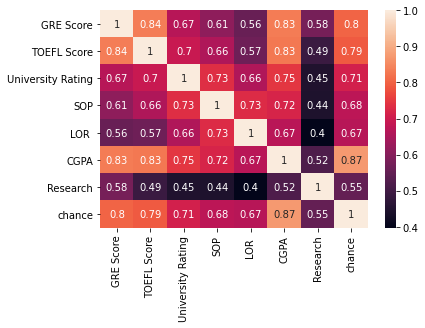

In [43]:
plt.figure(figsize=(6, 4)); sb.heatmap(scores.corr(), annot=True)

In [44]:
# Looks like there are a lot of interactions here.
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
X = poly.fit_transform(scores[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research']])

model = LogisticRegression(max_iter=500, penalty="l2")
model.fit(X,
          scores['chance'] >= .7)

model.coef_

array([[-1.11466677e-03, -1.73655857e-01, -5.88601197e-02,
        -1.57274117e-03, -1.73412931e-03, -1.79703208e-03,
        -4.65041997e-03, -2.84031770e-04,  2.43469986e-03,
        -1.26789337e-02,  4.08265830e-03, -6.41960130e-04,
         4.40670356e-03,  7.53733614e-03,  9.30997534e-04,
         1.97770990e-02, -7.34302506e-03, -1.34289778e-03,
        -7.92959176e-03, -1.67917160e-03,  2.47951049e-03,
        -2.55453094e-03,  6.69284256e-04,  3.32764251e-04,
        -1.39190105e-03,  1.34048410e-03, -2.49803936e-03,
        -9.23898288e-04, -5.93270512e-04, -3.34395246e-04,
         6.10762628e-04, -6.68703447e-04, -8.77339357e-04,
         7.94865590e-05,  6.15285634e-05, -2.84031770e-04]])

Do the PCA.

In [56]:
# Extract two principle components
pca = PCA(n_components=2)
scores[['feat1', 'feat2']] = pca.fit_transform(scores[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
                                                       'LOR ', 'CGPA', 'Research']])

# Multiply so that each feature correlates positively with prob of admission
scores['feat1'] *= np.sign(scores['chance'].corr(scores['feat1']))
scores['feat2'] *= np.sign(scores['chance'].corr(scores['feat2']))

# Convert these to percentile rankings
scores[['x1', 'x2']] = scores[['feat1', 'feat2']].rank(pct=True)
scores.to_csv("julia/probinp.csv")

Slightly generalized loss function here. The penalty for misclassification is still the absolute difference between the assessment and the cutoff, but now misclassification runs on a continuum, where the weight is the absolute difference between the predicted outcome and probability of admissions.

In [57]:
def loss(true_admit, X, params):
    a = np.empty(2)
    a[0], a[1], rho, p = params
    
    assessments = CES(X, a, rho)
    admit_pred = assessments >= p
    return sum(abs(admit_pred[i] - true_admit[i]) *   # How "right" the classifier was
               abs(assessments[i] - p)                      # How far student was from the boundary
               for i in range(len(true_admit)))

Optimize. This time $\rho$ comes out slightly less than linear.

In [58]:
x0 = [0.5] * 4
out = minimize(lambda params: loss(scores['chance'], scores[['x1', 'x2']], params),
               x0=x0,
               constraints=LinearConstraint(np.array([1, 1, 0, 0]), 1, 1),
               bounds=[(0, np.inf),
                       (0, np.inf),
                       (0, 1),
                       (0, 1)])
print(out)

     fun: 18.95089425332109
     jac: array([19.45698023, 19.47623658,  0.04346943, -0.25999975])
 message: 'Optimization terminated successfully'
    nfev: 75
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.62143681, 0.37856319, 0.97830356, 0.35471581])


Since the problem is nonconvex, there can be many local optima. Here is a marginally better, strongly nonlinear solution I found using Ipopt (see the `julia/` directory).

In [135]:
a2 = np.array([0.5053464046714162, 0.49465359532855563])
rho2 = 1.1574215278079482e-13
p2 = 0.29119354182105534

loss(scores['chance'], scores[['x1', 'x2']], np.hstack((a2, rho2, p2)))

18.909714785088553

Plot both solutions.

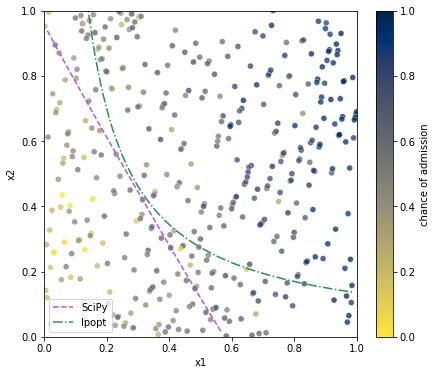

In [132]:
a = np.empty(2); a[0], a[1], rho, p = out.x
x_p = np.arange(0.01, ((p**rho)/a[0])**(1/rho), 0.01)

plt.figure(figsize=(7, 6))
plt.plot(x_p, CES_plot(x_p, a, rho, p), color="mediumorchid", ls="dashed", label="SciPy")

x_p = np.arange(0.01, 1, 0.01)
plt.plot(x_p, CES_plot(x_p, a2, rho2, p2), color="seagreen", ls="dashdot", label="Ipopt")

ax = sb.scatterplot(data=scores, x='x1', y='x2', hue='chance', alpha=0.75, palette="cividis_r")
plt.xlim(0, 1); plt.ylim(0, 1); ax.get_legend().remove(); plt.legend(["SciPy", "Ipopt"])

sm = plt.cm.ScalarMappable(cmap="cividis_r")
ax.figure.colorbar(sm, label="chance of admission")
plt.savefig("plots/probresults.pdf", bbox_inches="tight")

Compare the CES score with chance of admission. It is a fairly good indicator.

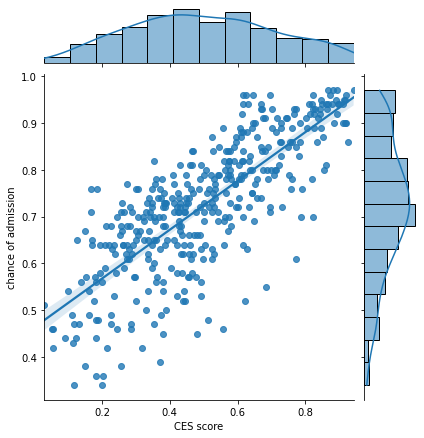

In [134]:
sb.jointplot(x=CES(scores[['x1', 'x2']], a, rho), y=scores['chance'], kind="reg")
plt.xlabel("CES score"); plt.ylabel("chance of admission");

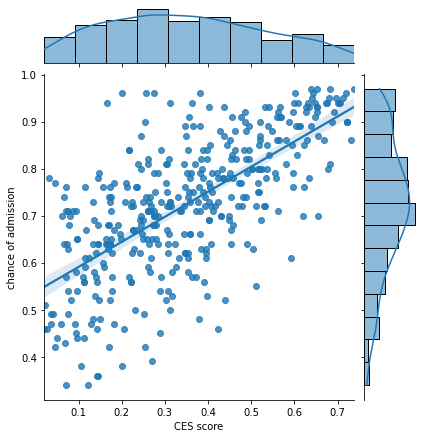

In [136]:
sb.jointplot(x=CES(scores[['x1', 'x2']], a2, rho2), y=scores['chance'], kind="reg")
plt.xlabel("CES score"); plt.ylabel("chance of admission");